📂 Using dataset path: /kaggle/input/sartaj-dataset/Training
📁 Found class folders: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
✅ Total images found: 2870
🧾 Class distribution:
 class
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
Found 1951 validated image filenames belonging to 4 classes.
Found 345 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


E0000 00:00:1755006794.710629      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755006794.907259      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/61 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.4263 - loss: 1.3428

E0000 00:00:1755006822.942857      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755006823.140546      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


61/61 ━━━━━━━━━━━━━━━━━━━━ 110s 852ms/step - accuracy: 0.5683 - loss: 1.0439 - val_accuracy: 0.5275 - val_loss: 1.2588
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.8660 - loss: 0.3860 - val_accuracy: 0.7391 - val_loss: 0.6737
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.9146 - loss: 0.2482 - val_accuracy: 0.8000 - val_loss: 0.5517
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 390ms/step - accuracy: 0.9391 - loss: 0.1695 - val_accuracy: 0.8551 - val_loss: 0.4452
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.9581 - loss: 0.1270 - val_accuracy: 0.8696 - val_loss: 0.4137


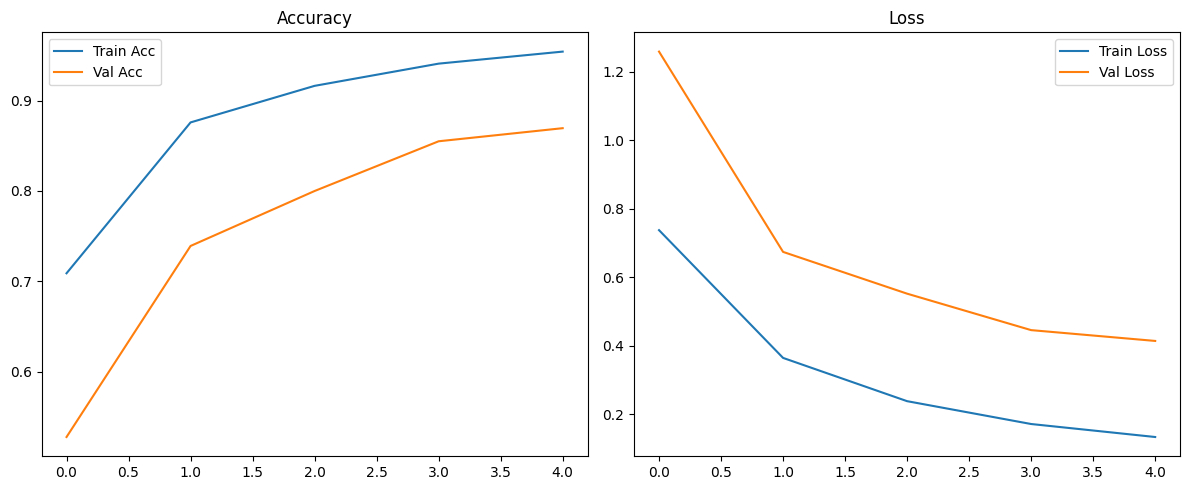

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.8750 - loss: 0.4111
✅ Test Accuracy (Keras): 0.8780
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.89      0.87      0.88       165
meningioma_tumor       0.81      0.83      0.82       165
        no_tumor       0.91      0.87      0.89        79
 pituitary_tumor       0.93      0.93      0.93       165

        accuracy                           0.88       574
       macro avg       0.88      0.88      0.88       574
    weighted avg       0.88      0.88      0.88       574



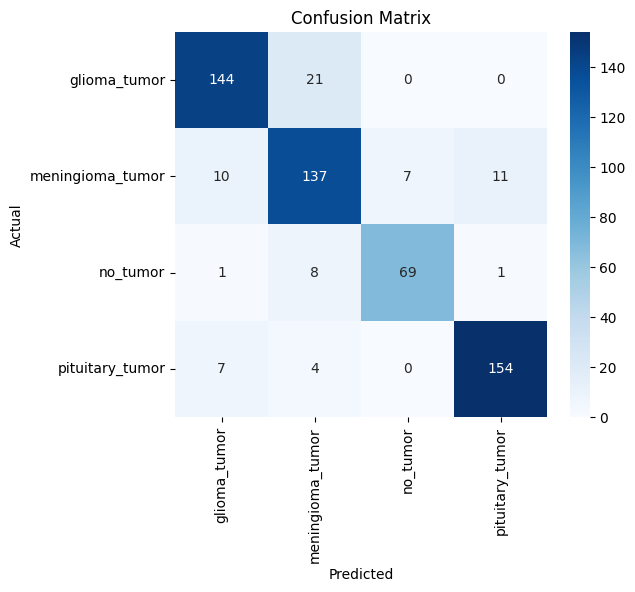


🎯 Overall Test Accuracy (manual calc): 87.80%


In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ⚙️ Parameters
BASE_PATH = "/kaggle/input/sartaj-dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 4

# 🔍 Step 1: Find the folder that contains class directories
def find_image_root(base_path):
    for root, dirs, files in os.walk(base_path):
        # If folder contains only image files, skip
        if any(fname.lower().endswith(('.jpg', '.jpeg', '.png')) for fname in files):
            return os.path.dirname(root)  # The folder ABOVE images is the class folder
    return base_path

DATASET_PATH = find_image_root(BASE_PATH)
print(f"📂 Using dataset path: {DATASET_PATH}")

# 🧠 Step 2: Load image paths and labels
image_paths, labels = [], []
class_dirs = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print(f"📁 Found class folders: {class_dirs}")

for class_dir in class_dirs:
    class_path = os.path.join(DATASET_PATH, class_dir)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images found: {len(df)}")
print("🧾 Class distribution:\n", df['class'].value_counts())

if len(df) == 0:
    raise ValueError("❌ No images found. Check dataset structure!")

# 🧪 Step 3: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)

# 🔄 Step 4: Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_gen = valid_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# 🔧 Step 5: Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ⚙️ Step 6: Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 📦 Step 7: Callbacks
checkpoint = ModelCheckpoint('mobilenetv2_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🏋️ Step 8: Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[checkpoint, earlystop])

# 📈 Step 9: Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🧪 Step 10: Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy (Keras): {acc:.4f}")

# 🧾 Step 11: Classification report and confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ✅ Step 12: Overall Accuracy (manual)
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 Overall Test Accuracy (manual calc): {overall_accuracy * 100:.2f}%")


In [8]:
!ls /kaggle/input/sartaj-dataset
!ls /kaggle/input/sartaj-dataset/Brain_tumar_dataset
!ls /kaggle/input/sartaj-dataset/Brain_tumar_dataset/Harvard_medical_dataset
!ls /kaggle/input/sartaj-dataset/Brain_tumar_dataset/Harvard_medical_dataset/Testing



Testing  Training
ls: cannot access '/kaggle/input/sartaj-dataset/Brain_tumar_dataset': No such file or directory
ls: cannot access '/kaggle/input/sartaj-dataset/Brain_tumar_dataset/Harvard_medical_dataset': No such file or directory
ls: cannot access '/kaggle/input/sartaj-dataset/Brain_tumar_dataset/Harvard_medical_dataset/Testing': No such file or directory
